# Web Scraping 

# Mini Project: Searching for a Camping Trailer on Craigslist

## Submitted by Shawn Strasser
### July 23, 2022




### Project Idea
I'd like to buy a camping trailer. It should be less than $20k, and light enough to tow behind a small SUV. To find something that meets these criteria, I'll scrape listings from my local Salem, Oregon Craigslist RVs site. There are several different pages with 120 listings each. I'll need to navigate to each listing on the first page, read the description and other info, and then move on to the next page, until all pages and listings are read.

Scraping this type of data could be useful not just for personal use to help make a purchase, but it could aslo be used potentially in sales industry to monitor prices of things like cars/RVs, and understand trends. This same thing could be done potentially on other marketplaces too, like Facebook marketplace.

### Scraping Data
The easiest way to do this will be with a crawler. Craigslist does not have an API to pull data, only to make posts. To avoid my IP address from getting blocked, I'm limiting requests to one at a time with a loop and adding sleep time between requests. Below is the code used for my Scrapy spider.

I ran the bot from the command prompt using: *scrapy runspider spider_craigslist.py -o trailers.json*

In [1]:
import scrapy
import time

class CraigslistSpider(scrapy.Spider):
    name = 'RVs'
    # This is the Salem, OR Craigslist site for Recreational Vehicles
    start_urls = ['https://salem.craigslist.org/search/rva']

    def parse(self, response):
        page_links = response.xpath('//*[@id="search-results"]//li/a/@href')
        for link in page_links:
            time.sleep(2) #sleep time to avoid being detected as a bot
            yield response.follow(link, self.parse_page)

        pagination_links = response.xpath('//*[@class="button next"]/@href')[0]
        if not not pagination_links:
            yield response.follow(pagination_links.extract(), self.parse)
        else:
            print('**Done Scraping!!!***' * 15)

    def parse_page(self, response):
        print('**SCRAPING!**' * 15)
        time.sleep(2)
        yield {
            'title': response.xpath('//*[@id="titletextonly"]/text()').extract()[0],
            'url' : response.url,
            'price' : response.xpath('//*[@class="price"]/text()').extract()[0],
            'latitude' : response.xpath('//*[@id="map"]/@data-latitude').extract()[0],
            'longitude' : response.xpath('//*[@id="map"]/@data-longitude').extract()[0],
            'description' : response.xpath('//*[@id="postingbody"]/text()').extract()[1]
        }

### Data Cleansing
This is text data. It needs to be put in usable formats/datatypes for analysis, and have some useful features extracted from the text descriptions.

In [2]:
# Import packages and read data
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Inspect the data
df = pd.read_json('trailers.json')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        515 non-null    object 
 1   url          515 non-null    object 
 2   price        515 non-null    object 
 3   latitude     515 non-null    float64
 4   longitude    515 non-null    float64
 5   description  515 non-null    object 
dtypes: float64(2), object(4)
memory usage: 24.3+ KB
None


,title,url,price,latitude,longitude,description
0,2022 Coleman Lantern 264RLWE Travel Trailer 30...,https://salem.craigslist.org/rvs/d/dallas-2022...,"$32,000",44.922500,-123.32000,"\nColeman Lantern 264RLWE Travel Trailer, 30' ..."
1,🌸 Super Cute Double Slide Half Ton Towable 🌸,https://salem.craigslist.org/rvd/d/springfield...,"$27,900",44.029279,-122.92345,\nI am selling a Super Cute Double Slide Fores...
2,2022 Keystone RV Arcadia 3660RL,https://salem.craigslist.org/rvd/d/creswell-20...,"$73,975",43.905800,-123.02840,\n
3,2022 Northwood Nash 24B,https://salem.craigslist.org/rvd/d/creswell-20...,"$39,975",43.905800,-123.02840,\n
4,2019 Shockwave Toy Hauler,https://salem.craigslist.org/rvs/d/independenc...,"$43,000",44.848100,-123.18790,\nDry camping toy hauler extreme! 2019 Forest ...


Define some helper functions to extract useful features from the title and description. Specifically, I'd like to know the year, if it has a shower, and if it is light enough to tow with a small SUV.

In [3]:
def year(x):
    '''Extracts the year from text, returns a 0 if result is invalid'''
    year_expr = r'\d\d\d\d' # 4 digit number
    try:
        year = re.compile(year_expr).search(x).group()
        year = int(year)
    except:
        year = 0
    if year > 2022 or year < 1960:
        year = 0
    return year

def shower(x):
    '''Checks if shower is in description'''
    return True if 'shower' in x else False

def towable(x):
    '''Checks if light keywords are in description'''
    keywords = ['light ', 'light-weight', 'pop up', 'pop-up', 'towable', 'tow-able', 'easy to tow', 'minivan']
    return any(keyword in x for keyword in keywords)

Create new features

In [4]:
df['price'] = df['price'].str.replace('[\$\,]', '', regex=True).astype(int)
df['year'] = df['title'].apply(year)
df['towable'] = df['description'].apply(towable)
df['shower'] = df['description'].apply(shower)

Remove price outliers

In [5]:
# Remove price outliers by limiting price range from $100 to $100,000
df = df[df['price'] <= 100000]
df = df[df['price'] >= 100]

### Data Visualization

A scatter plot of Price vs Year shows that the price of an RV appears to drop exponentially as it ages. This suggests that if budget is a concern, an older RV will have to do. I've also added a scatter plot for the listings filtered down to just those flagged as "towable" because that is what I'm interested in. The same trend appears to hold true.  

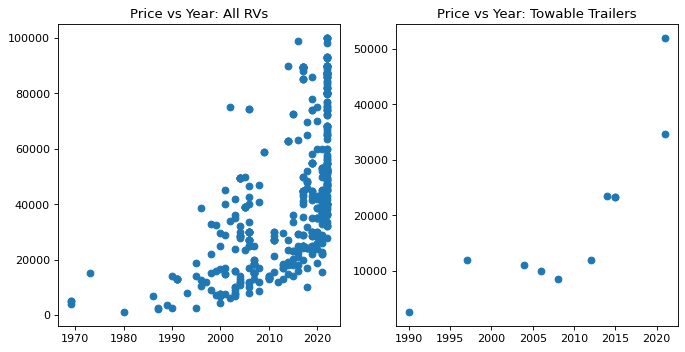

In [6]:
# Draw a scatter plot of Price vs Year
# First remove listing without a year
df_withyear = df[df['year']!=0]

f1 = plt.figure(figsize=(10, 5), dpi=80)
ax1 = f1.add_subplot(1,2,1)
ax2 = f1.add_subplot(1,2,2)
ax1.scatter(df_withyear['year'], df_withyear['price'])
ax1.set_title('Price vs Year: All RVs')
ax2.scatter(df_withyear[df_withyear['towable']]['year'], df_withyear[df_withyear['towable']]['price'])
ax2.set_title('Price vs Year: Towable Trailers')
plt.show()

A histogram of price shows a two-hump ditribution, probably one of lower-end RVs with a mean around 20k, and high-end RVs with a mean around 80k

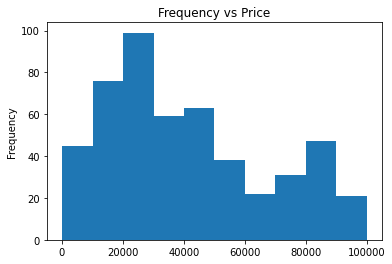

In [7]:
df['price'].plot.hist(title='Frequency vs Price')
plt.show()

Now, to narrow down the search to a "towable" camper trailer. This histogram shows the number of those RVs in each price bin. I'd prefer it included a shower but wanted to see how that impacted the price, and it looks like there are several options with a shower on the lower end.

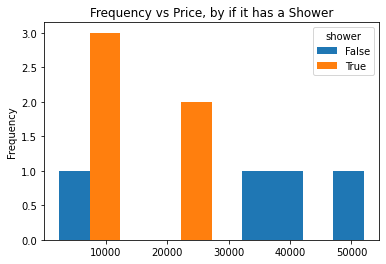

In [8]:
df_towable = df[df['towable']==True][['price', 'shower']]
df_towable.pivot(columns='shower', values='price').plot.hist(title='Frequency vs Price, by if it has a Shower')
plt.show()

### Final Selection
Below are the top 3 results for towable trailers with a shower, sorted by price. 

In [9]:
final_selection = df[(df['towable']) & (df['shower'])].sort_values('price')
final_selection.head(3)

,title,url,price,latitude,longitude,description,year,towable,shower
222,2008 Rockwood Mini-lite,https://salem.craigslist.org/rvs/d/dallas-2008...,8500,44.9225,-123.3200,\nSelling our 2008 Forest River Rockwood Mini-...,2008,True,True
465,2004 Tahoe Transport Toy Hauler,https://salem.craigslist.org/rvs/d/salem-2004-...,10995,44.9026,-122.9074,"\n2004 Tahoe Transport Toy Hauler 21', microwa...",2004,True,True
423,2012 keystone hideout,https://salem.craigslist.org/rvs/d/turner-2012...,12000,44.8476,-122.9501,"\nprice reduced to $12,00 this weekend for a ...",2012,True,True


In [11]:
# URL for the top selection
final_selection['url'].iloc[0]

'https://salem.craigslist.org/rvs/d/dallas-2008-rockwood-mini-lite/7508856831.html'

After using the URL to review the top three listing, my first choice is the 2008 Rockwood Mini-lite for $8,500. Now, to check if it's still avaiable!

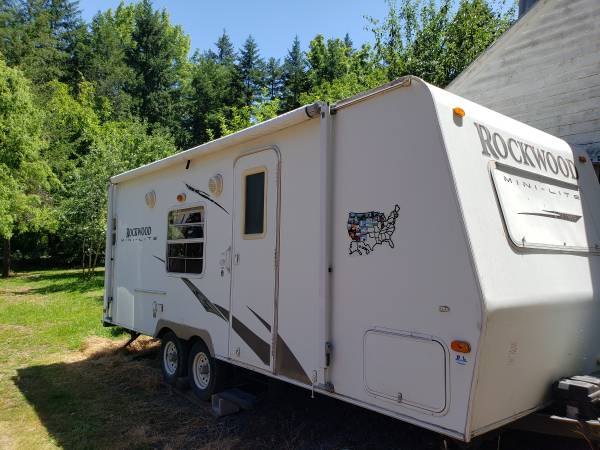